In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.draw import disk as pdisk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_multiotsu, rank
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema

'''
"Amyg_CE_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619" +
"DG_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039"
'''

scan_name = "CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903"

path_comm = "/home/ula/catfish/test_scans/" + scan_name + "/"
path_orig = path_comm + "orig.tif"

dapi_path = path_comm + "1.tif"
homer_path = path_comm + "2.tif"
arc_path = path_comm + "3.tif"

In [2]:
img = io.imread(dapi_path)

In [3]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + (1-frac)*(max_lum - min_lum)

In [4]:
class Nucleus(): 
    def __init__(self, nucelusProps, approxEllipse,  idno):
        self.nucelusProps = nucelusProps
        self.approxEllipse = approxEllipse
        self.idno = idno
   

In [5]:
def quantile_wrapper(image):
    return np.quantile(image, 0.99)

In [6]:
def custom_thre(image, frac):
    block_size = 150
    overlap = 70
    
    x = 0
    
    min_thre = np.max(image)
    thre_map = np.zeros_like(image)
    while x < thre_map.shape[0]:
        prev_x = x
        x = min(x + block_size, thre_map.shape[0])
        y = 0
        while y < thre_map.shape[1]:
            prev_y = y
            y = min(y + block_size, thre_map.shape[1])
            subimage = image[prev_x:x, prev_y:y]
            if np.count_nonzero(subimage) > 0:
                thre_map[prev_x:x, prev_y:y] = np.quantile(subimage, frac)
                if np.min(thre_map[prev_x:x, prev_y:y]) < min_thre:
                    min_thre = np.min(thre_map[prev_x:x, prev_y:y])
    thre_map = ndi.gaussian_filter(thre_map, 20)
    return thre_map, min_thre
            

In [7]:
def background_filter(flattened_img):
    hist, bins = np.histogram(flattened_img, 200)
    mode_idx = np.argmax(hist)
    mode = bins[mode_idx]
    return mode

In [8]:
def reflect(image_ts):
    height = image_ts.shape[0]
    image_ts = np.transpose(image_ts)
    to_ret = np.copy(image_ts)
    print(height)
    print(len(image_ts[0]))
    for col_no, column in enumerate(image_ts):
        nonzero = False
        idx = 0
        while not nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        start_idx = idx - 1
        while nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        stop_idx = idx - 1
        reflection = np.flip(column[start_idx:stop_idx])
        reflect_offset_up = start_idx - len(reflection)
        reflect_offset_down = stop_idx + len(reflection)
        to_ret[col_no][max(0, reflect_offset_up):start_idx] = reflection[max(0, -reflect_offset_up):]
        to_ret[col_no][stop_idx:min(reflect_offset_down, height)] = reflection[:min(len(reflection)+1, height - stop_idx)]
    return np.transpose(to_ret)
            

In [9]:
def calculate_ieg_segm_mask(image_ts):
    reflected = reflect(image_ts)
    
    background = ndi.generic_filter(reflected, background_filter, size=50)
    skewness = skew(image_ts[image_ts>0])
    mask = image_ts > (threshold_otsu(image_ts[image_ts>0])*5/skewness + background)
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness

In [10]:
def ieg_segmentation(image_ts, thresh_down, thresh_up, thresh_range, mask): 

        
    elev_map = sobel(image_ts)
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]

   
    labels = watershed(-elev_map, markers, mask=mask)

    label_image = label(labels, connectivity = 1)
    
    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()
    
    ax[0].imshow(image_ts)
    ax[0].set_title("Labelled")
    
    
    masked = np.ma.masked_array(data = image_ts, mask = mask, fill_value = 0).filled()
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")
    areas = np.array([])
        
    intensities = np.array([])
    intensities_normalized = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image, intensity_image=image_ts):
        areas = np.append(areas, region.area)
        reg_app_wide = pdisk(region.centroid, 7, shape= image_ts.shape)
        reg_approx = pdisk(region.centroid, 5, shape= image_ts.shape)
        reg_intensity = 2*np.sum(image_ts[reg_approx])-np.sum(image_ts[reg_app_wide])
        
        
        avg_bgr_int = (np.sum(image_ts[reg_app_wide])-np.sum(image_ts[reg_approx]))/(len(reg_app_wide[0])-len(reg_approx[0]))
        avg_reg_int = np.sum(image_ts[reg_approx])/len(reg_approx[0])
        #reg_intensity = avg_reg_int - avg_bgr_int
        
        intensities = np.append(intensities, np.sum(reg_approx))
        intensities_normalized = np.append(intensities_normalized, reg_intensity)
    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        
        reg_app_wide = pdisk((region.centroid[1], region.centroid[0]), 7)
        reg_approx = pdisk((region.centroid[1], region.centroid[0]), 5)
        reg_intensity = 2*np.sum(reg_approx) - np.sum(reg_app_wide)
        if reg_intensity > -1000:
            color = "white"
        else:
            color = "red"
        circ = mpatches.Circle((region.centroid[1], region.centroid[0]), 5, 
                               fill=False, edgecolor=color, linewidth=2)
        
        if region.area >= thresh_up:
            ax[0].add_patch(circ)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)    
            ax[0].add_patch(circ)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()

    return nuclei, regions_to_reconsider, areas, intensities, intensities_normalized

In [11]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    ratio_thre = 1.6
    
    image_ts_orig = copy.copy(image_ts)
    
    image_ts = opening(image_ts, disk(2))
    
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)
    ax = axes.ravel()
    fig.set_figwidth(10)
    thresh = threshold_otsu(image_ts[image_ts>0])/2
    #closed = closing(image_ts > T_mean, disk(11))
    thresholds = threshold_multiotsu(image_ts)

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, 
                                             mask = ~(image_ts > thresh), fill_value = 0).filled()

    local_masked_global = opening(local_masked_global, disk(5))
    elev_map = sobel(mh.gaussian_filter(image_ts,3))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    ax[0].imshow(local_masked_global)
    ax[0].set_title("local_masked_global")
    

    label_image = label(labels, connectivity = 1)

    #ax[0].imshow(label_image)
    #ax[0].set_title("Labelled")
    ax[1].imshow(image_ts_orig)
    ax[1].set_title("Labelled")
    


    ax[2].imshow(image_ts)
    ax[2].set_title("orig img")


    extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(path_comm + 'labelled.tif', bbox_inches=extent)
    
    areas = np.array([])
    areas_div = np.array([])
    intensities = np.array([])
    ellipse_axes_ratios = np.array([])
    
    regions_to_reconsider = []
    
    for region in regionprops(label_image, intensity_image=image_ts):
        areas = np.append(areas, region.area)
        intensities = np.append(intensities, region.mean_intensity)
        if region.minor_axis_length == 0:
            ax_ratio = 0
        else:
            ax_ratio = region.major_axis_length/region.minor_axis_length
        ellipse_axes_ratios = np.append(ellipse_axes_ratios, ax_ratio)
    
    std = np.std(areas)
    mean = np.mean(areas)
    
    thresholds = threshold_multiotsu(areas)
    print("thres ", thresholds)
    nuclei = np.array([])
    for region in regionprops(label_image):
        if region.area > 10:#thresholds[0]/2:
            #areas = np.append(areas, region.area)
            alpha = (-180/math.pi)*(region.orientation)
            approxEllipse = mpatches.Ellipse((region.centroid[1],region.centroid[0]), region.minor_axis_length,
                                                             region.major_axis_length,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
            
            if region.minor_axis_length == 0:
                print("major ", region.major_axis_length)
                ax_ratio = 0
            else:
                ax_ratio = region.major_axis_length/region.minor_axis_length
            
            #wartość 1400 z hist????
            if ax_ratio * region.area > 1500:
                areas_div = np.append(areas_div, region.area)
                x = 0.25*region.major_axis_length*math.sin(math.radians(-alpha))
                y = 0.25*region.major_axis_length*math.cos(math.radians(-alpha))
                approxEllipse = mpatches.Ellipse((region.centroid[1]-x,region.centroid[0]-y), 
                                                 region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='green', linewidth=1)  
                new_nucleus = Nucleus(region, copy.copy(approxEllipse), len(nuclei))
                nuclei = np.append(nuclei, new_nucleus) 
                ax[1].add_patch(approxEllipse)
                
                approxEllipse = mpatches.Ellipse((region.centroid[1]+x,region.centroid[0]+y), 
                                                 region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='green', linewidth=1)  
                new_nucleus = Nucleus(region, copy.copy(approxEllipse), len(nuclei))
                nuclei = np.append(nuclei, new_nucleus) 
                ax[1].add_patch(approxEllipse)
            else:
                new_nucleus = Nucleus(region, copy.copy(approxEllipse), len(nuclei))
                nuclei = np.append(nuclei, new_nucleus) 
                #ax[1].add_patch(approxEllipse)

            ax[1].add_patch(approxEllipse)
                
             
    
    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    
    return nuclei, ellipse_axes_ratios, areas,intensities

In [12]:
h_thre, h_background, h_skewness = calculate_ieg_segm_mask(homer_im)

NameError: name 'homer_im' is not defined

In [ ]:
a_thre, a_background, a_skewness = calculate_ieg_segm_mask(arc_im)

In [ ]:
mask = homer_im > (threshold_otsu(homer_im[homer_im>0])*5/h_skewness + h_background/2)
homer_locations,_, homer_areas,homer_intensities, homer_int_norm = ieg_segmentation(homer_im, 0, 30, 21, mask)

In [ ]:
print(len(homer_locations))

In [ ]:
plt.imshow(a_background)
plt.show()

In [ ]:
mask = arc_im > (threshold_otsu(arc_im[arc_im>0])*10/a_skewness + a_background)
arc_locations,_, arc_areas,arc_intensities, arc_int_norm = ieg_segmentation(arc_im, 0, 30, 21, mask)

In [ ]:
print(len(arc_int_norm[arc_int_norm !=0]))
hist = np.histogram(arc_int_norm, 100)
extrema = argrelextrema(hist[0], np.less, order=3)
print(extrema[0], hist[0][extrema[0][0]])
plt.hist(arc_int_norm, 100)
for extr in extrema[0]:
    print(hist[1][extr])
    plt.axvline(hist[1][extr], color = "red")
plt.axvline(threshold_otsu(arc_int_norm), color = "yellow")
plt.show()

In [ ]:
plt.hist(homer_int_norm, 200)
plt.show()

<IPython.core.display.Javascript object>


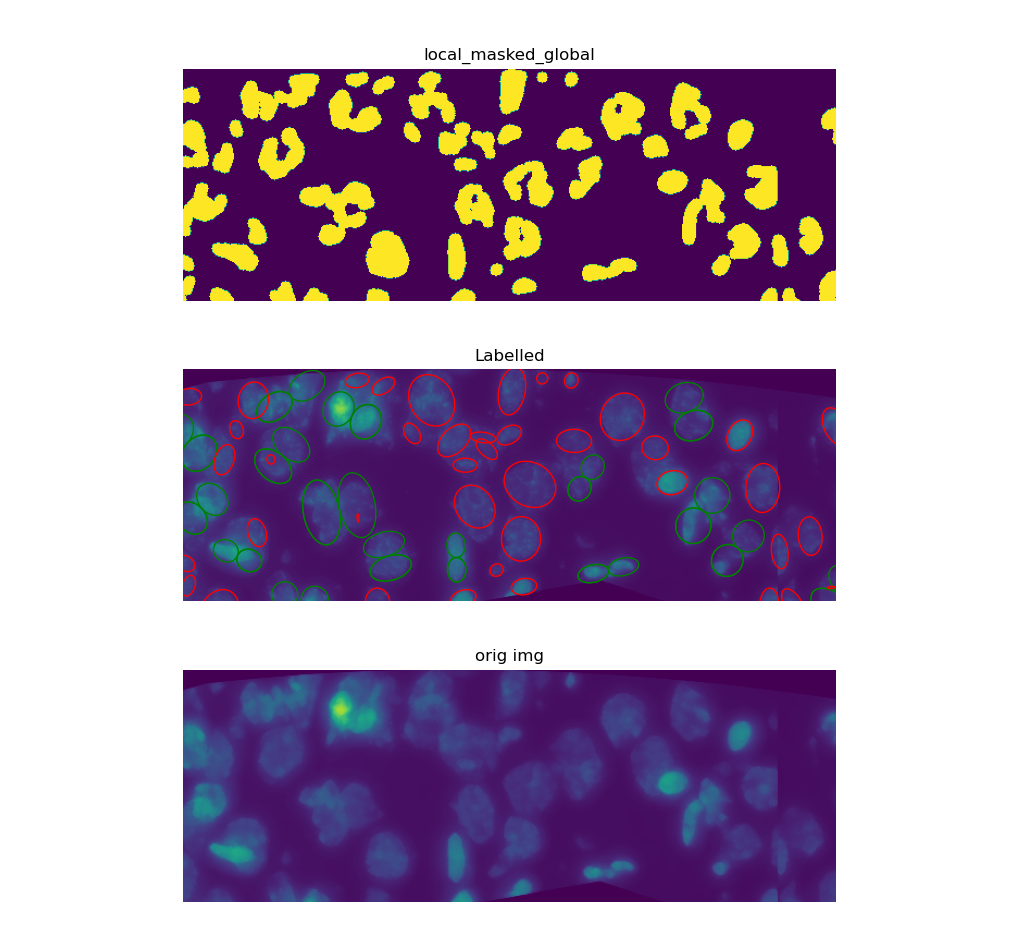

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


thres  [297.39648438 819.40820312]
968


In [13]:
image = io.imread(dapi_path)
#ostatni parametr - local threshold range, im większy, tym mniej krytyczny wobec najbliższego otoczenia
#czyli - zwiększać, jeżeli mocno obcina granice neuronów, zmniejszać jeśli za bardzo scala
nuclei, ellipse_axes_ratios, areas, intensities = dapi_segmentation(image,10, 75, 1250, 53)
print(len(nuclei))


In [ ]:
'''
plt.ioff()
prod = ellipse_axes_ratios*areas
thresholds = threshold_multiotsu(areas)
plt.hist(areas[areas>10], 200)
plt.axvline(thresholds[0], color="red")
plt.axvline(thresholds[1], color="green")
plt.axvline(threshold_otsu(areas[areas>thresholds[0]]), color="red")
plt.show()

plt.ioff()
plt.hist(ellipse_axes_ratios[ellipse_axes_ratios>0], 200)
plt.show()
'''

In [ ]:
'''
c_thre, min_thre = custom_thre(arc_im, 0.75)
thre_eq = np.max(c_thre) - min_thre
plt.ioff()
plt.hist(arc_im[arc_im>0], 200)
thre_eq = threshold_otsu(arc_im[arc_im>0])
skewness = skew(arc_im[arc_im>0])
plt.axvline(thre_eq, color='red')
thre_eq = threshold_otsu(arc_im[arc_im>0])*10/skewness
plt.axvline(thre_eq, color='green')

hist, bins = np.histogram(arc_im[arc_im>0], 200)
mode_idx = np.argmax(hist)
mode = bins[mode_idx]

plt.axvline(mode, color='yellow')
plt.show()

plt.hist(homer_im[homer_im>0], 200)

skewness = skew(homer_im[homer_im>0])
c_thre, min_thre = custom_thre(homer_im, 0.75)
thre_eq = np.max(c_thre) - min_thre
thre_eq = threshold_otsu(homer_im[homer_im>0])
plt.axvline(thre_eq, color='red')
thre_eq = threshold_otsu(homer_im[homer_im>0])*10/skewness
plt.axvline(thre_eq, color='green')

hist, bins = np.histogram(homer_im[homer_im>0], 200)
mode_idx = np.argmax(hist)
mode = bins[mode_idx]
print(mode_idx)
plt.axvline(mode, color='yellow')
plt.show()

plt.imshow(reflect(homer_im))
plt.show()
'''

In [ ]:
arc_im = io.imread(arc_path)
arc_locations,_,arc_areas,arc_intensities, mask, background = ieg_segmentation(arc_im, 0, 30, 21, 0.15)

In [ ]:

plt.imshow(homer_im > (threshold_otsu(homer_im[homer_im>0])*5/skewness + h_background))
plt.show()

In [ ]:
homer_im = io.imread(homer_path)
homer_locations,_, homer_areas,homer_intensities, h_background, h_mask = ieg_segmentation(homer_im, 0, 30, 21, 0.15)

In [ ]:
arc_im.shape

In [ ]:
def prepare_coords_set(coords_tab):
    return set(tuple([m, n]) for m, n in zip(coords_tab[:,0], coords_tab[:,1]))

def find_ieg_colloc(ieg_locs, nuclei, to_reevaluate):
    ieg_positive = np.array([])
    ieg_pos_count = np.array([])
    fig, ax = plt.subplots(figsize=(6, 6))
    full_image = io.imread(path_orig)
    ax.imshow(full_image)
    counter = 0
    for nucleus in nuclei:
        nucleus_patch = copy.copy(nucleus.approxEllipse)
        ieg_no = 0
        if counter %100 == 0:
            print(counter)
        counter += 1
        for ieg_dot in ieg_locs:
            ieg_centroid = ieg_dot.centroid      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            
            tmp = nucleus.approxEllipse.contains_point((ieg_centroid[1], ieg_centroid[0]))
            
            if (tmp):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus.idno)
                     
                    minr, minc, maxr, maxc = ieg_dot.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='red', linewidth=1)
                    
                    nucleus_patch.set_color('white')
                    #ax.add_patch(rect)   
        if ieg_no > 1:
            to_reevaluate = np.append(to_reevaluate, nucleus)
        if ieg_no > 0 :
            ieg_pos_count = np.append(ieg_pos_count, ieg_no)
        ax.add_patch(nucleus_patch)   
    ax.set_axis_off()

    fig.tight_layout()
    plt.title("colloc")
    plt.show()
    return ieg_positive, ieg_pos_count, to_reevaluate

In [ ]:
to_reevalueate = []

arc_pos, arc_counts, arc_mult =  find_ieg_colloc(arc_locations, nuclei, to_reevalueate)
homer_pos, homer_counts, homer_mult =  find_ieg_colloc(homer_locations, nuclei, to_reevalueate)


In [ ]:
plt.ioff()
print(len(arc_counts), len(arc_counts[arc_counts>2]))
hist = plt.hist(ellipse_axes_ratios, 100)
plt.axvline(np., color='red')
plt.show()


In [ ]:
image = io.imread(dapi_path)
print(np.max(image))
plt.ioff()
local_thresh = threshold_local(image, 149, offset=0)
#thresholds = threshold_multiotsu(image[image>local_thresh])


#for thresh in thresholds:
#    plt.axvline(thresh, color='r')
print(threshold_otsu(image[image>0]), threshold_otsu(image))
#plt.axvline(threshold_otsu(image), color='red')
#plt.axvline(np.median(image), color='green')


#plt.axvline(np.quantile(image, 0.99), color='pink')
#plt.axvline(np.quantile(image[image>0], 0.99), color='black')
hist = plt.hist(image[image>local_thresh/2].flatten(), 255)
plt.show()

image = io.imread(dapi_path)

In [ ]:
from skimage.feature import blob_dog, blob_log, blob_doh

subimage = image[1300:1500, 4300:4600]
dapi_segmentation(subimage, 4, 10, 1250, 49)
im_bw = subimage>threshold_otsu(subimage)/1.5
blobs = blob_log(im_bw, max_sigma=30, min_sigma = 3, num_sigma=6, threshold=0.3, overlap = 0.5)
fig, ax = plt.subplots()
ax.imshow(im_bw, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
plt.show()
plt.imshow(subimage)
plt.show()

In [ ]:
im = 255-rgb2gray(io.imread('../../Downloads/index.png'))
dapi_segmentation(im, 4, 60, 1250, 49)

In [ ]:
angle_step = 30  # degrees
angles = np.arange(0, 360, angle_step)

ax = plt.subplot(aspect='equal')
step_x = 3
step_y = 3
x = 0
y = 0
majo = 6
mino = 2
for angle in angles:
    ellipse = mpatches.Ellipse((x,y), mino, majo, angle=angle, alpha=0.1)
    ax.add_artist(ellipse)
    cx_shift = 0.25*majo*math.sin(math.radians(-angle))
    cy_shift = 0.25*majo*math.cos(math.radians(-angle))
    approxEllipse = mpatches.Ellipse((x-cx_shift,y-cy_shift), mino, majo/2,angle,
                           fill=False, edgecolor='green', linewidth=1)  
    ax.add_artist(approxEllipse)
    approxEllipse = mpatches.Ellipse((x+cx_shift,y+cy_shift), mino, majo/2,angle,
                           fill=False, edgecolor='green', linewidth=1)  
    ax.add_artist(approxEllipse)
    x += step_x
    y += step_y
    

plt.xlim(-5, 40)
plt.ylim(-5, 40)
plt.savefig("/home/ula/catfish/test_scans/tst.tif")

plt.show()


In [ ]:
plt.ioff()
arc_im = io.imread(arc_path)
rr, cc = pdisk((1000, 5000), 20)
arc_im[rr, cc] = 1000
plt.imshow(arc_im)
figure = plt.gcf() # get current figure
figure.set_size_inches(arc_im.shape[1]/1000, arc_im.shape[0]/1000)
plt.savefig("/home/ula/catfish/test_scans/tst.tif", dpi=1000)
plt.show()

In [ ]:
print(pdisk((1000, 5000), 2))